# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image. Output the visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
8. Video Pipeline

In [1]:
# Import useful libraries
import numpy as np
import glob
import pickle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Camera Calibration

In [2]:
# Fetch all calibration Images.
cal_images = glob.glob("camera_cal/calibration*.jpg")

In [3]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

chessboardShape = (9,6)
# Arrays to store object points, image points, orignal images and points drawn images.
objpoints = [] 
imgpoints = [] 
cornersDrawnImaged = [] 
original_images = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboardShape, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        original_images.append(img)

        # Draw and display the corners
        drawn_img = cv2.drawChessboardCorners(img.copy(), chessboardShape, corners, ret)
        cornersDrawnImaged.append(drawn_img)

### Show corners drawn on the image

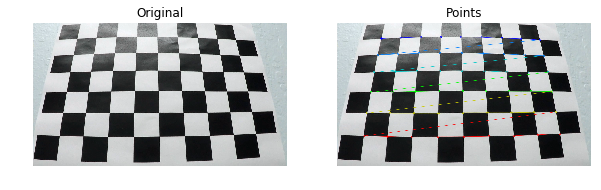

In [4]:
index = 7
original_img = original_images[index]
drawn = cornersDrawnImaged[index]

#Plot Orignal and Corners drawn images side by side
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(10, 8))
ax1.axis('off'),  ax2.axis('off')
ax1.imshow(original_img)
ax1.set_title('Original')
ax2.imshow(drawn)
ax2.set_title('Points')

### Show undistorted chess board

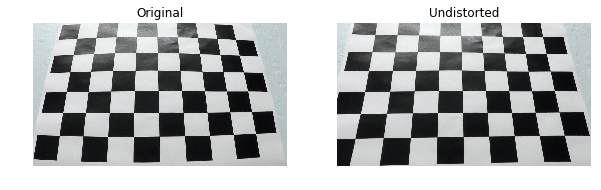

In [5]:
img_size = (original_img.shape[1], original_img.shape[0])
# Obtain Camera matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Undistort Orignal image using the Camera matrix (mtx) and distortion coefficients (dist)
undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)

# Plot Orignal and Undistorted image side by side
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 8))
ax1.axis('off'),  ax2.axis('off')
ax1.imshow(original_img)
ax1.set_title('Original')
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted')

## 2. Apply a distortion correction to raw images.

In [6]:
def undistortIt(original_img, visualize = False):
    """
    Unistort the image and visualize if True
    
    Return undistorted_img
    """
    undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)
    
    # Plot Orignal test image of the lane and Undistoted image side by side
    if visualize:
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18, 12))
        ax1.axis('off'),  ax2.axis('off')
        ax1.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original')
        ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted')
    return undistorted_img

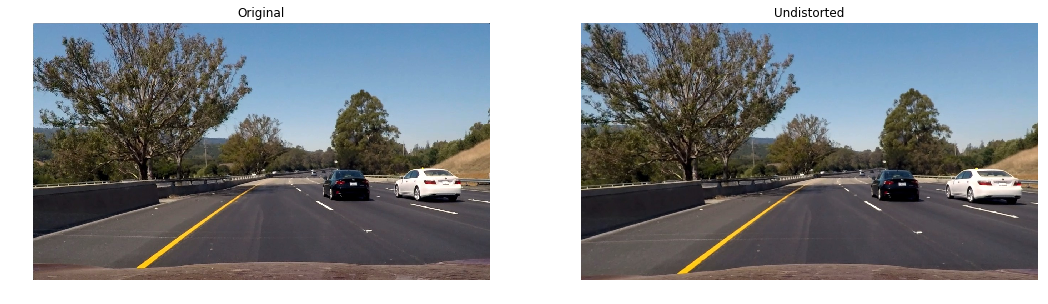

In [7]:
original_img = cv2.imread("test_images/test6.jpg")
undistorted_straight_lines1 = undistortIt(original_img, visualize=True)

## 3. Use color transforms and gradients to create a thresholded binary image.

### Explore HLS channels
Notice how Channel S highlights the lane clearly.

(<matplotlib.image.AxesImage at 0x7fbdfa9a7240>,
 <matplotlib.text.Text at 0x7fbdfa9ff2e8>)

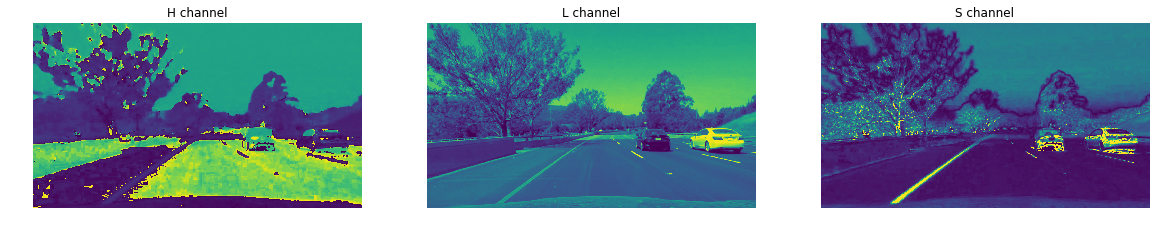

In [8]:
# Seperate HLS channels from a Undistorted test image
hls_undistordted = cv2.cvtColor(undistorted_straight_lines1, cv2.COLOR_BGR2HLS)
h_undistorted = hls_undistordted[:,:,0]
l_undistorted = hls_undistordted[:,:,1]
s_undistorted = hls_undistordted[:,:,2]

# Plot these channels side by side.
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20, 10))
ax1.axis('off'),  ax2.axis('off'), ax3.axis('off')
ax1.imshow(h_undistorted),  ax1.set_title('H channel')
ax2.imshow(l_undistorted),  ax2.set_title('L channel')
ax3.imshow(s_undistorted),  ax3.set_title('S channel')

### Apply Threshold to S channel, Apply Sobel in X and Y orientation and combine the binary image.

In [9]:
def sobelIt(img, orientation, t_min, t_max):
    """
    Apply sobel filter on given orientation and apply threshold t_min and t_max.
    
    Return binary image (sobinary) after applying filter
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation == 'x':
        x,y = 1,0
    else:
        x,y = 0,1

    sobel = cv2.Sobel(gray, cv2.CV_64F, x,y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobinary = np.zeros_like(scaled_sobel)
    sobinary[(scaled_sobel >= t_min) & (scaled_sobel <= t_max)] = 1
    
    return sobinary

def threshColor(s_channel, t_min, t_max):
    """
    Threshold the S channel with t_min and t_max
    
    Return thresholded binary image (s_binary)
    """
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= t_min) & (s_channel <= t_max)] = 1
    return s_binary

def applyFilter(undistorted_img, visualize = False):
    """
    Threshold S channel, Apply Sobel on X and Y orientation and combine them. Visualise of True
    
    Return combined binary image (s_sobXY_binary)
    """
    hls_undistordted = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2HLS)
    s_undistorted = hls_undistordted[:,:,2]
    
    # Apply Sobel in X
    sobX = sobelIt(undistorted_img, 'x',40, 150)
    # Apply Sobel in Y
    sobY = sobelIt(undistorted_img, 'y',90, 150)
    # Threshold the S channel
    s_threshed = threshColor(s_undistorted, 160, 255)
    # Combine the binaries
    s_sobXY_binary = np.zeros_like(sobX)
    s_sobXY_binary[(sobX == 1) | (sobY == 1) | (s_threshed==1) ] = 1
    
    # If visualise true, plot S channel, SobX, SobY and combined
    if visualize:
        fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(20, 10))
        ax1.axis('off'),  ax2.axis('off'), ax3.axis('off'),  ax4.axis('off')
        ax1.imshow(s_threshed, cmap = 'gray'),  ax1.set_title('S Threshold')
        ax2.imshow(sobX, cmap = 'gray'),  ax2.set_title('Sobel X')
        ax3.imshow(sobY, cmap = 'gray'),  ax3.set_title('Sobel Y')
        ax4.imshow(s_sobXY_binary, cmap = 'gray'),  ax4.set_title('Combined')
    return s_sobXY_binary

In [10]:
undistorted_images= []
binary_images = []
all_image_paths = glob.glob("test_images/*.jpg")

def undistortAll():
    """
    Undistort all test images and add to an array
    """
    for img in all_image_paths:
        original_img = cv2.imread(img)
        undistorted_images.append(undistortIt(original_img))

undistortAll()
        
def binarizeAll(undistorted_images):
    """
    Apply filter to the undistorted images
    """
    for img in undistorted_images:
        binary = applyFilter(img)
        binary_images.append(binary)
    
binarizeAll(undistorted_images)

In [11]:
# Delete this cell later
test_undistorted_images= []
test_binary_images = []
test_all_image_paths = sorted(glob.glob("frames/*.jpg"))

def undistortAll():
    """
    Undistort all test images and add to an array
    """
    for img in test_all_image_paths:
        original_img = cv2.imread(img)
        test_undistorted_images.append(undistortIt(original_img))

undistortAll()
        
def binarizeAll(undistorted_images):
    """
    Apply filter to the undistorted images
    """
    for img in undistorted_images:
        binary = applyFilter(img)
        test_binary_images.append(binary)
    
binarizeAll(test_undistorted_images)

### Visualize the affects of thresholding, gradients and combination of both seperately.

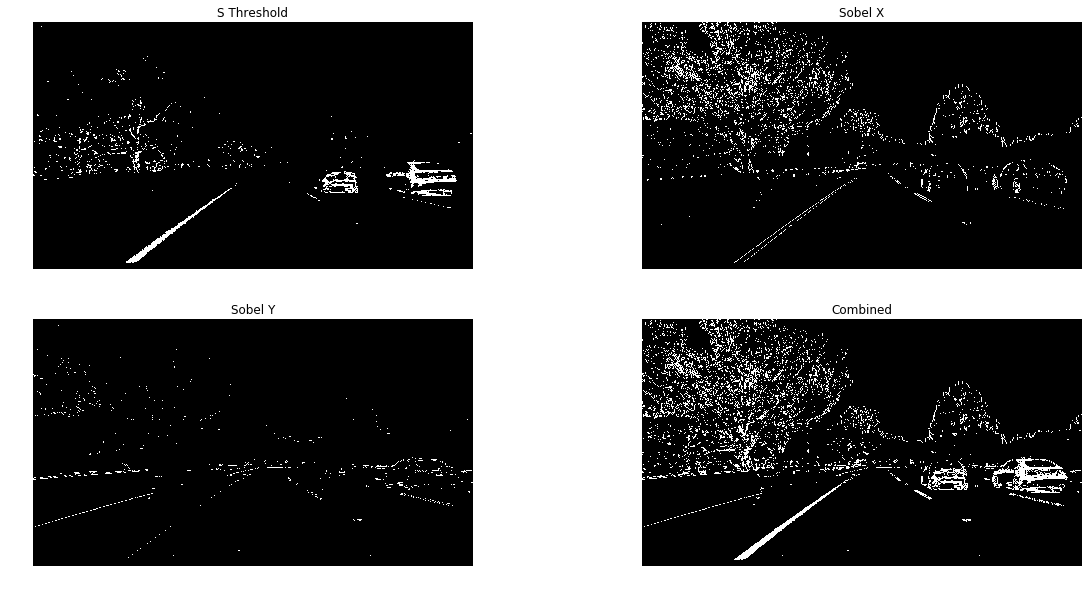

In [12]:
_ = applyFilter(undistorted_images[3], visualize=True)

## 4. Apply a perspective transform to rectify binary image

Perspective transform gives a bird's eye view which helps us determine the actual curvature of the lane.

In [13]:
def perspectivize(undistorted_image, binary_image, visualize = False):
    """
    Generate transformation matrix M and inverse transformaition matrix Minv. 
    Warp the binary_image and undistorted_image.
    Marke the areas of interest on undistorted_image
    Visualize Orignal, Marked, Transformed orignal and Transformed Bindary if visualize = True
    
    Return warped binary and color images (warped, warped_colored)
    """
    
    # Points of interest on the lane 
    src = np.float32([(220, 720), 
                      (570, 470), 
                      (720, 470),
                      (1110, 720)])
    # Points where we would like to map it to
    dst = np.float32([(370, 720), 
                      (370, 0), 
                      (870, 0),
                      (870, 720)])

    global M, Minv
    imgsize = (binary_image.shape[1], binary_image.shape[0])
    # Obtain Transformation Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Obtain Inverse Transformation Matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the binary_image
    warped = cv2.warpPerspective(binary_image, M, imgsize, flags=cv2.INTER_LINEAR)
    # Convert undistorted_image to RGB
    undistorted_rgb_img = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB).copy()
    # Warp undistorted_rgb_img image
    warped_colored = cv2.warpPerspective(undistorted_rgb_img, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # If Visualize true, plot images side by side
    if visualize:
        # Convert undistorted_image to RGB
        lined_undistorted_img = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB).copy()        

        left_bottom = (220, 720)
        right_bottom = (1110, 720)
        left_top = (570, 470)
        right_top = (720, 470)

        color = [255,0,0]
        width = 2
        
        # Draw lines on lined_undistorted_img showing the areas of interest
        cv2.line(lined_undistorted_img, left_bottom, right_bottom, color, width)
        cv2.line(lined_undistorted_img, left_bottom, left_top, color, width)
        cv2.line(lined_undistorted_img, left_top, right_top, color, width)
        cv2.line(lined_undistorted_img, right_top, right_bottom, color, width)
        
        # Plot Orignal, Marked, Transformed and Binary transformed images
        fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
#         ax1.axis('off'),  ax2.axis('off'), ax3.axis('off'),ax4.axis('off'),
        ax1.imshow(undistorted_rgb_img), ax1.set_title('Orignal')
        ax2.imshow(lined_undistorted_img), ax2.set_title('Marked')
        ax3.imshow(warped_colored), ax3.set_title('Perspective')
        ax4.imshow(warped, cmap='gray'), ax4.set_title('Binarized Perspective')
    
    return warped, warped_colored

In [14]:
rgb_warped_images = []
binary_warped_images = []
# Transform all test images
for i in range(len(undistorted_images)):
    warped, warped_colored = perspectivize(undistorted_images[i], binary_images[i])
    binary_warped_images.append(warped)
    rgb_warped_images.append(warped_colored)

In [15]:
# Delete later
test_rgb_warped_images = []
test_binary_warped_images = []
# Transform all test images
for i in range(len(test_undistorted_images)):
    warped, warped_colored = perspectivize(test_undistorted_images[i], test_binary_images[i])
    test_binary_warped_images.append(warped)
    test_rgb_warped_images.append(warped_colored)

### Visualize Orignal image, Areas of Interst marked, Transformed and binarized image

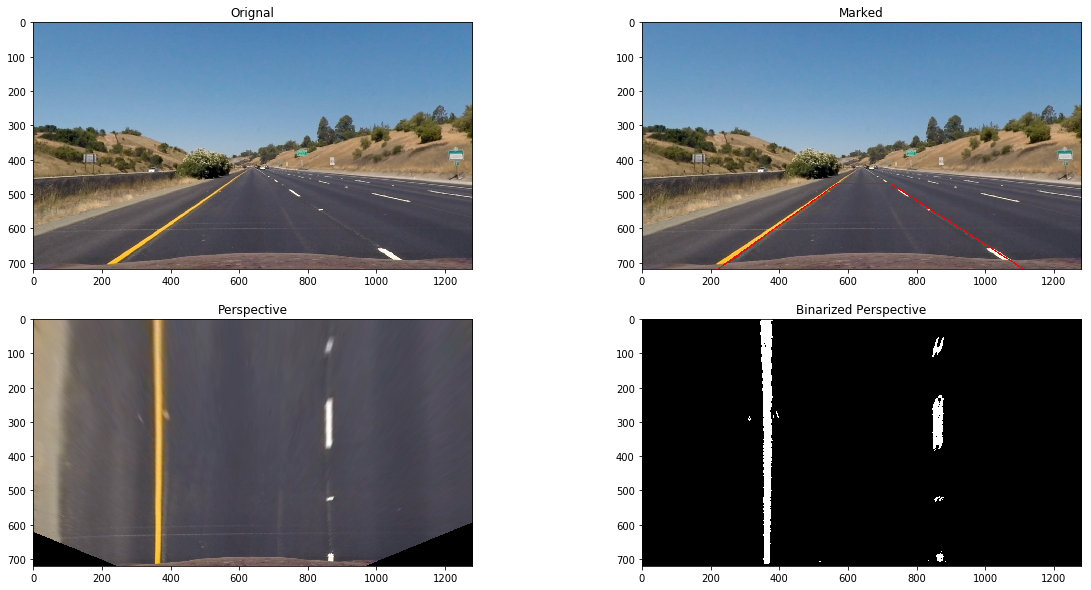

In [16]:
# Example Visualization
_,_ = perspectivize(undistorted_images[0], binary_images[0], visualize=True)

## 5. Detect lane pixels and fit to find the lane boundary.

### Plot a histogram of bottom half of the image
Notice the two peaks that show the left and the right lane.

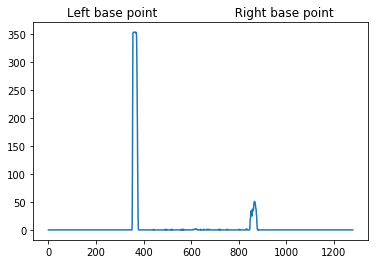

In [17]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped_images[0][int(binary_warped_images[0].shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.title('Left base point                    Right base point')

In [18]:
ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

In [1]:
def fitLanes(binary_warped, nwindows = 9, margin = 100, minpix = 50, visualize = False, count = 0):
    """
    Detect left and right lane points iteratively on each of nwindows with a margin of 100px.
    The minimum pixels required to consider is minpix = 50
    Fit a polynomial to the lane lines.
    Visualize if True
    
    Returns (left_fit_m, right_fit_m, left_fit, right_fit)
    """
    
    maxpix = 2500
    change_x_per_window_minor = 10
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # The highest point in the histogram on the left from center
    leftx_base = np.argmax(histogram[:midpoint]) 
    # The highest point in the histogram on the right from center
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows (binary_warped shape[0] is actually y, not x)
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current highest positions to be updated for each window
    leftx_current = [leftx_base, 0]
    rightx_current = [rightx_base, 0]
    leftx, lefty, rightx, righty = [],[],[],[]

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_currentxs = []
    right_currentxs = []
    signs_left = []
    signs_right = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current[0] - margin
        win_xleft_high = leftx_current[0] + margin
        win_xright_low = rightx_current[0] - margin
        win_xright_high = rightx_current[0] + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                
        change_x_per_window = 13
            
        leftx_new, rightx_new = 0, 0
        
        if len(good_left_inds) > minpix and len(good_left_inds) < maxpix:
            # Find the median x of the indeces            
            leftx_new = np.int(np.median(nonzerox[good_left_inds]))
            # Save for logs
            left_currentxs.append((window, leftx_current[0], leftx_new))
            # Sign provides a general direction of the lane. If right inclined, positive            
            signs_left.append(np.sign(leftx_new-leftx_current[0]))
            majority_sign = np.sign(np.sum(signs_left))
            if majority_sign == 0:
                majority_sign = 1
            minority_sign = - majority_sign
            # Change in x from previous window
            diff = leftx_new-leftx_current[0]            
            # Skips the the window if the center changes much more than previous median                
            if ((np.sign(diff) == majority_sign or np.sign(diff) == 0) and (abs(diff) < abs(window - leftx_current[1] + 1)*change_x_per_window)) or ((abs(diff) < abs(window - leftx_current[1] + 1)*change_x_per_window_minor)):
                leftx_current[0] = leftx_new
                leftx_current[1] = window + 1
                left_lane_inds.append(good_left_inds)
        
        if len(good_right_inds) > minpix and len(good_right_inds) < maxpix:
            # Fin the median x of the indeces            
            rightx_new = np.int(np.median(nonzerox[good_right_inds]))
            right_currentxs.append((window, rightx_current[0], rightx_new))
            # Sign provides a general direction of the lane. If right inclined, positive
            signs_right.append(np.sign(rightx_new-rightx_current[0]))
            majority_sign = np.sign(np.sum(signs_right))
            if majority_sign == 0:
                majority_sign = 1
            minority_sign = - majority_sign
            # Change in x from previous window
            diff = rightx_new-rightx_current[0]
            # Skips the the window if the center changes much more than previous median
            if ((np.sign(diff) == majority_sign or np.sign(diff) == 0) and (abs(diff) < abs(window - rightx_current[1] + 1)*change_x_per_window)) or ((abs(diff) < abs(window - rightx_current[1] + 1)*change_x_per_window_minor)):            
                rightx_current[0] = rightx_new
                rightx_current[1] = window + 1
                right_lane_inds.append(good_right_inds)

    # Append these indices to the lists
    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    if len(right_lane_inds)> 0:
        right_lane_inds = np.concatenate(right_lane_inds)
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

    # Extract left and right line pixel positions
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    else:
        left_fit = None
        left_fit_m = None

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    else:
        right_fit = None
        right_fit_m = None
    
    # Get right and left pixels from the fit for plotting
    if left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Color the lanes
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # If visualize is True, plot binary_img and marked image side by side
    if visualize:
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        ax1.axis('off'),  ax2.axis('off')
        ax1.imshow(binary_warped, cmap='gray'), ax1.set_title('Binary warped')
        ax2.imshow(out_img), ax2.set_title('Points(Red, blue), lines(yellow), windows(green)')
        ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)

    return (left_fit_m, right_fit_m, left_fit, right_fit, out_img)

In [2]:
def fit_lane_from_previous_window(binary_warped, left_fit, right_fit, left_fit_m, right_fit_m, visualize = False):
        
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Append these indices to the lists
    if len(left_lane_inds) > 0:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    if len(right_lane_inds)> 0:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
    left_fit_new, left_fit_new_m, right_fit_new, right_fit_new_m = None, None, None, None
    detected = True
    
    # Fit a second order polynomial to each
    if not list(leftx) or not list(lefty):
        detected = False
        left_fit_new, left_fit_new_m = left_fit, left_fit_m
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
        left_fit_new_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)

    if not list(rightx) or not list(righty):
        detected = False
        right_fit_new, right_fit_new_m = right_fit, right_fit_m
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        right_fit_new_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Get right and left pixels from the fit for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    # Color the lanes
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    if visualize:
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        ax1.axis('off'),  ax2.axis('off')
        ax1.imshow(binary_warped, cmap='gray'), ax1.set_title('Binary warped')
        ax2.imshow(out_img), ax2.set_title('Points(Red, blue), lines(yellow), windows(green)')
        ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)
    
    return (left_fit_new_m, right_fit_new_m, left_fit_new, right_fit_new, out_img, detected)    

In [21]:
sane_left, sane_left_m, sane_right, sane_right_m = None, None, None, None
REUSED_LEFT, REUSED_RIGHT = 0, 0

def check_lane_sanity(left_fit, right_fit, left_fit_m, right_fit_m, count = 0):    
    """
    Check if the left_fit and right_fit changes drastically. If it does, use the previously stored fits
    """    
    global sane_left
    global sane_right
    global sane_left_m
    global sane_right_m
    global REUSED_LEFT
    global REUSED_RIGHT 
    max_reuse = 6
    THRESHOLD_RIGHT = 30
    THRESHOLD_LEFT = 50
    reset = False
    
    # First run, save the fits directly
    if sane_left is None and sane_right is None:
        sane_left = left_fit
        sane_right = right_fit
        sane_left_m = left_fit_m
        sane_right_m = right_fit_m
    else:
        # If left fit varies less than threshold, update the global value with the current fit
        if left_fit is not None and np.sum(np.abs(left_fit - sane_left)) < THRESHOLD_LEFT and REUSED_LEFT <= max_reuse:
            sane_left = left_fit
            sane_left_m = left_fit_m
            REUSED_LEFT = 0
        else:
            REUSED_LEFT += 1
        
        # If right fit varies less than threshold, update the global value with the current fit
        if right_fit is not None and np.sum(np.abs(right_fit - sane_right)) < THRESHOLD_RIGHT and REUSED_RIGHT <= max_reuse:
            sane_right = right_fit
            sane_right_m = right_fit_m
            REUSED_RIGHT = 0
        else:
            REUSED_RIGHT += 1
                   
    return sane_left_m, sane_right_m, sane_left, sane_right, reset

### Visualize the windows, nonzero points left in red & right in blue and the polyfit lines in yellow

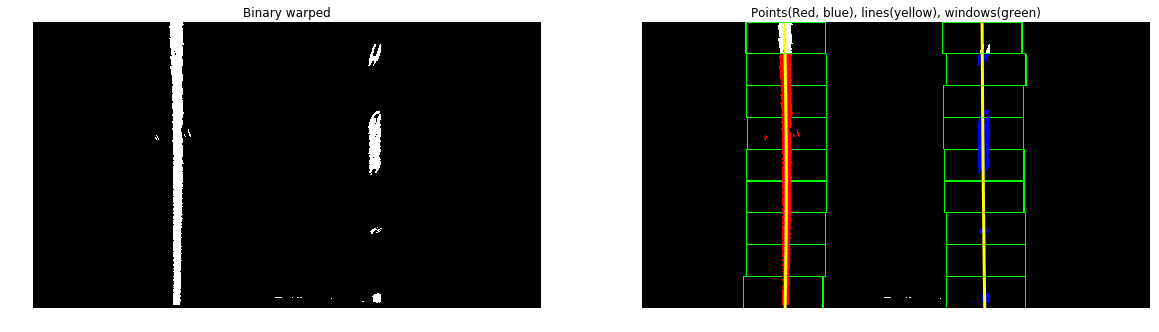

In [22]:
_,_,_,_,_ = fitLanes(binary_warped_images[0], nwindows = 9, margin = 100, minpix = 50, visualize = True)

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [24]:
def curvatures(binary_warped_image, left_fit_m, right_fit_m):
    """
    Calculate the left and right curvatures 
    
    Return (left_curverad, right_curverad)
    """
    y_eval = 719    
  
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    return (left_curverad, right_curverad)

In [25]:
# Caculate and print curvatures for all test images
for i, binary_img in enumerate(binary_warped_images):
    left_curvature, right_curvature = curvatures(binary_img,left_fit_m,right_fit_m)
    print('Path = {}'.format(all_image_paths[i]))
    print('\t Left: {:.2f} KM , Right: {:.2f} KM'.format(left_curvature/1000, right_curvature/1000))

Path = test_images/straight_lines1.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test3.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test5.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test6.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test1.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/straight_lines2.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test2.jpg
	 Left: 1.60 KM , Right: 1.10 KM
Path = test_images/test4.jpg
	 Left: 1.60 KM , Right: 1.10 KM


## 7. Warp the detected lane boundaries back onto the original image. 

In [26]:
def drawLineOverImage(img, binary_img,binary_marked, left_fit, right_fit, left_fit_m, right_fit_m):
    """
    Draw line over the image using polynomials left_fit and right_fit
    Fill the area of interest with green color on the warped image
    Unwarp the filled_binary image
    Superimpose the filled_binary image onto the undistorted image
    Embed text information on Left curvature, Right curvature and offset from the center of the lane.
    
    Return filled_rgb and filled_binary
    """
    ploty = np.linspace(0, 719, 720)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    filled_binary = np.zeros_like(img,dtype=np.uint8)    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(filled_binary, np.int_([pts]), (0,255, 0))    
    unwarp = cv2.warpPerspective(filled_binary, Minv, (binary_img.shape[1], binary_img.shape[0])) 
    filled_rgb = cv2.addWeighted(img, 1, unwarp, 0.3, 0)    
    
    left_curvature, right_curvature = curvatures(binary_img, left_fit_m, right_fit_m)
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    
    middle = lineLeft + (lineRight - lineLeft)/2
    actualCenter = xMax / 2
    difference = middle - actualCenter
    
    if difference > 0:
        diff = '{:.2f} m right'.format(difference)
    else:
        diff = '{:.2f} m left'.format(difference)

    font = cv2.FONT_HERSHEY_COMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(filled_rgb, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(filled_rgb, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(filled_rgb, 'Vehicle center off by {}'.format(diff), (50, 190), font, 1, fontColor, 2)
            
    filled_rgb[0:240,853:,:] = binary_marked[::3,::3]
        
    return (filled_rgb , filled_binary)

### Output the visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(<matplotlib.image.AxesImage at 0x7fbdfc5b1278>,
 <matplotlib.text.Text at 0x7fbdf806ec18>)

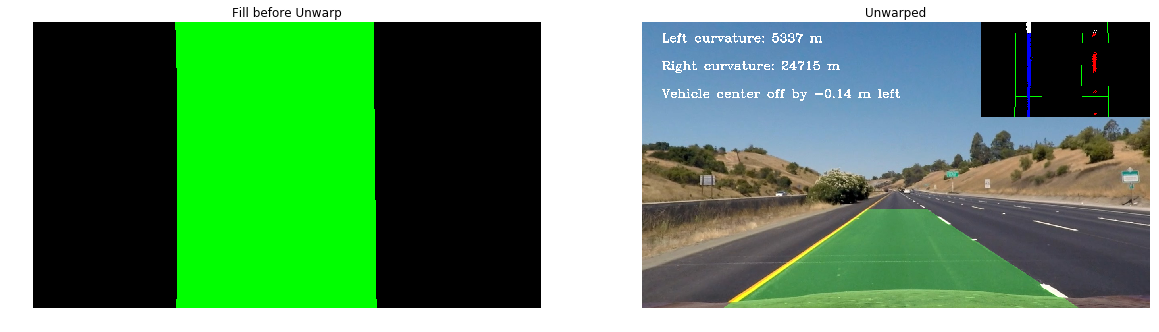

In [27]:
# Show Unwarped image blend with gree fill in our area of interest
left_fit_m, right_fit_m, left_fit, right_fit, binary_marked = fitLanes(binary_warped_images[0], nwindows = 9, margin = 100, minpix = 50)
output,lineoverimg = drawLineOverImage(undistorted_images[0], binary_warped_images[0], binary_marked, left_fit, right_fit, left_fit_m, right_fit_m)

# Plot filled binary image and superimposed on the orignal image side by side
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
ax1.axis('off'),  ax2.axis('off')
ax1.imshow(lineoverimg),  ax1.set_title('Fill before Unwarp')
ax2.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)),  ax2.set_title('Unwarped')

## 8. Pipeline (video)

In [29]:
from moviepy.editor import VideoFileClip
firstFrame = True
detected = True
reset = False

def steps(img):
    """
    Undistort the image, Apply filter, transform, fit lanes, draw lines and text over the image
    
    Returns processed output image
    """
    global firstFrame
    global detected
    global left_fit_m, right_fit_m, left_fit, right_fit
    global reset
    # Undistort img
    undistorted_image = undistortIt(img)
    # Apply filter in the undistorted_image
    binary_image = applyFilter(undistorted_image)
    # Apply perspective transform on the binary_image
    binary_warped, warped_colored = perspectivize(undistorted_image, binary_image)
    # fit lanes on to the binary_warped image
    REUSED_LEFT, REUSED_RIGHT = 0, 0
    sane_left, sane_left_m, sane_right, sane_right_m = None, None, None, None
    
    visualise = False
    disable_use_previous = True
     
    if not disable_use_previous and not firstFrame and detected and left_fit is not None and right_fit is not None and reset is False:
        left_fit_m_new, right_fit_m_new, left_fit_new, right_fit_new, binary_marked, detected = fit_lane_from_previous_window(binary_warped, left_fit, right_fit, left_fit_m, right_fit_m, visualize = visualise)    
    else:
        left_fit_m_new, right_fit_m_new, left_fit_new, right_fit_new, binary_marked = fitLanes(binary_warped, nwindows = 9, margin = 100, minpix = 50, visualize = visualise)
    
    left_fit_m, right_fit_m, left_fit, right_fit, reset = check_lane_sanity(left_fit_new, right_fit_new, left_fit_m_new, right_fit_m_new)
    firstFrame = False
    

    output,_ = drawLineOverImage(undistorted_image, binary_warped, binary_marked, left_fit, right_fit, left_fit_m, right_fit_m)
    return output

def pipeline(input_video, out_video_filename):
    """
    Get frames from the input_video and process it through the pipeline function
    Write the output to a file out_video_filename
    """
    left_fit_m, right_fit_m, left_fit, right_fit = None, None, None, None
#     input_clip = VideoFileClip(input_video).subclip(0, 5)
    input_clip = VideoFileClip(input_video)
    output_clip = input_clip.fl_image(steps)
    output_clip.write_videofile(out_video_filename, audio = False, verbose=False, progress_bar=False)
    
pipeline('project_video.mp4', 'output_video.mp4')